In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import rasterio as rio
import geopandas as gp

import fiona 
import rasterio
import rasterio.mask

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

from rasterio.mask import mask
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.lines import Line2D      
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

import matplotlib.pyplot as plt
from collections import OrderedDict 

from osgeo import gdal, osr, ogr
from tqdm import tqdm

In [2]:
# Helpers

def plot_basemaps(image, shp, title = None, cmap = 'viridis', ax = None, latlabels = True, lonlabels = True, vmax = None):
    imextent = gp.read_file(shp).set_crs("EPSG:4326").to_crs(4326).total_bounds
    shape_feature = ShapelyFeature(Reader("../shape/sierra_catchments.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='white', facecolor = 'none')

    minx, miny, maxx, maxy = imextent
    lllon, lllat = minx, miny
    urlon, urlat = maxx, maxy

    # Create a Stamen Terrain instance.
    stamen_terrain = cimgt.Stamen('terrain-background')

    # Create a GeoAxes in the tile's projection.
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels= False
    gl.right_labels = False
    if not latlabels:
        gl.left_labels = False
    if not lonlabels:
        gl.bottom_labels = False
    
    gl.xlocator = mticker.FixedLocator([-122,-121,-120,-119])
    gl.ylocator = mticker.FixedLocator(np.linspace(0,90,91))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8, 'color': 'gray', 'rotation': 45}
    gl.ylabel_style = {'size': 9, 'color': 'gray'}

    # Limit the extent of the map to a small longitude/latitude range.
    ax.set_extent([lllon, urlon, lllat, urlat])

    # Add the Stamen data at zoom level 8.
    ax.add_image(stamen_terrain, 8)
    
    im = ax.imshow(image,
        cmap=cmap, zorder=1, vmin = 0, vmax = vmax,
        origin="upper", alpha = 0.8,
        extent=(lllon, urlon, lllat, urlat),
        transform=ccrs.PlateCarree(),
    )

    # Add shapefile outline
    ax.add_feature(shape_feature, zorder = 2)
    
    # Set the title
    ax.set_title("{}".format(title), size = 12)
    
#     cbar = plt.colorbar(mappable=im,orientation='vertical', fraction=0.05, pad = 0.0125, ax = ax)

    return im

# Extract  means 

def calc_temporal_mean(file_list):
    '''
    comupte temporal mean of a for a given list of tiffs
    '''
    
    out = {}
    
    for fn in file_list:
        ext = os.path.split(fn)[1]
        src = rio.open(fn)
        arr = src.read(1)
        arr[arr==src.nodata] = np.nan
        out[ext] = arr
    
    return np.nanmean(np.dstack(list(out.values())), axis =2)

In [3]:
# read files setup dirs 
gdf = gp.read_file("../shape/sierra_catchments.shp")

stids_all = list(gdf['stid'].values)
nodata_stids = ["MCR", "CFW"]

stids = [x for x in stids_all if x not in nodata_stids]

# Define outdirs
results_dir = "../results/moving_win_30"
outdir = os.path.join(results_dir,"merged")
clipdir = os.path.join(results_dir,"clipped")

if not os.path.exists(outdir):
    os.mkdir(outdir)
    
if not os.path.exists(clipdir):
    os.mkdir(clipdir)

# Set the vars we have
prcp_vars = ['lag_bf','cor_bf','sum', 'lag_sr', 'cor_sr']
smlt_vars = ['lag_bf','cor_bf','sum', 'lag_sr', 'cor_sr']

# Clip by watershed into the clipped dir

for stn_id in stids[:]:
    
    print("****" * 15)
    print("PROCESSING : {}".format(stn_id))
    print("****" * 15)

    # get shapefile 
    catch_shp = os.path.abspath("../shape/{}.shp".format(stn_id))
    
    # Get files matching the wshed 
    wshed_files = [os.path.join(results_dir,x) for x in os.listdir(results_dir) if stn_id in x]
    wshed_files = [os.path.abspath(x) for x in wshed_files]
    
    for fn in wshed_files:
        varfn = os.path.split(fn)[1]
        outfn = os.path.join(clipdir,varfn) 
        if not os.path.exists(outfn):
            cmd = '''gdalwarp -dstnodata -999 -cutline {} -crop_to_cutline {} {}'''.format(catch_shp, fn, outfn)
            os.system(cmd)
    print("DONE ---")



************************************************************
PROCESSING : SJF
************************************************************
DONE ---
************************************************************
PROCESSING : TLG
************************************************************
DONE ---
************************************************************
PROCESSING : ISB
************************************************************
DONE ---
************************************************************
PROCESSING : NAT
************************************************************
DONE ---
************************************************************
PROCESSING : MHB
************************************************************
DONE ---
************************************************************
PROCESSING : NML
************************************************************
DONE ---
************************************************************
PROCESSING : ORO
**********************************

In [4]:
# Merge files 

for prcp_var, smlt_var in zip(prcp_vars[:], smlt_vars[:]):
    seas_year_prcp_str = "prcp"+ "_" + prcp_var 
    seas_year_smlt_str = "smlt"+ "_" + smlt_var 

    prcp_files = [os.path.join(clipdir,x) for x in os.listdir(clipdir) if seas_year_prcp_str in x]
    smlt_files = [os.path.join(clipdir,x) for x in os.listdir(clipdir) if seas_year_smlt_str in x]

    # merge and write 
    prcp_merged_fn = os.path.join(outdir,"{}.tiff".format(seas_year_prcp_str))
    if not os.path.exists(prcp_merged_fn):
        g_prcp = gdal.Warp(prcp_merged_fn, prcp_files, format="GTiff")
        g_prcp = None # Close file
        print("WROTE {}".format(prcp_merged_fn))

    smlt_merged_fn = os.path.join(outdir,"{}.tiff".format(seas_year_smlt_str))
    if not os.path.exists(smlt_merged_fn):
        g_prcp = gdal.Warp(smlt_merged_fn, smlt_files, format="GTiff")
        g_prcp = None # Close file
        print("WROTE {}".format(smlt_merged_fn))


In [5]:
results = {}

for smlt, prcp in zip(smlt_vars,prcp_vars):
    smlt_fn = os.path.join("../results/moving_win_30/merged/smlt_{}.tiff").format(smlt)
    prcp_fn = os.path.join("../results/moving_win_30/merged/prcp_{}.tiff").format(prcp)
    sm_arr = rio.open(smlt_fn).read(1)
    pr_arr = rio.open(prcp_fn).read(1)
    sm_arr[sm_arr==-999] = np.nan
    pr_arr[pr_arr==-999] = np.nan
    results["smlt_" + smlt] = sm_arr
    results["prcp_"+ prcp] = pr_arr
    print(smlt_fn, prcp_fn)

../results/moving_win_30/merged/smlt_lag_bf.tiff ../results/moving_win_30/merged/prcp_lag_bf.tiff
../results/moving_win_30/merged/smlt_cor_bf.tiff ../results/moving_win_30/merged/prcp_cor_bf.tiff
../results/moving_win_30/merged/smlt_sum.tiff ../results/moving_win_30/merged/prcp_sum.tiff
../results/moving_win_30/merged/smlt_lag_sr.tiff ../results/moving_win_30/merged/prcp_lag_sr.tiff
../results/moving_win_30/merged/smlt_cor_sr.tiff ../results/moving_win_30/merged/prcp_cor_sr.tiff


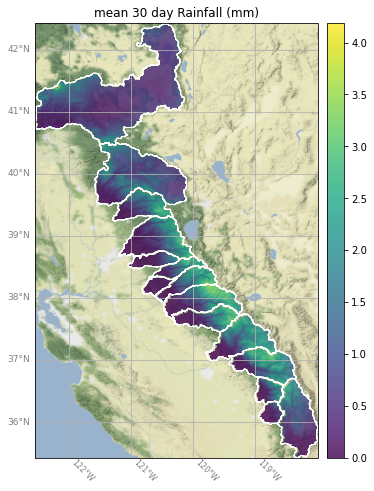

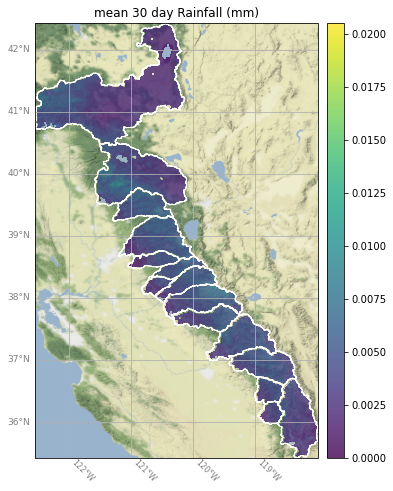

In [6]:
# SUMs

fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(results['prcp_sum'], "../shape/sierra_catchments.shp", "mean 30 day Rainfall (mm)", cmap = 'viridis', ax = axes, latlabels = True, lonlabels = True)
fig.subplots_adjust(wspace=0.02,hspace =0.00)
cax = fig.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,0.02,axes.get_position().y1-axes.get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)

plt.show()

# SMLT 
fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(results['smlt_sum'], "../shape/sierra_catchments.shp", "mean 30 day Rainfall (mm)", cmap = 'viridis', ax = axes, latlabels = True, lonlabels = True)
fig.subplots_adjust(wspace=0.02,hspace =0.00)
cax = fig.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,0.02,axes.get_position().y1-axes.get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)

plt.show()

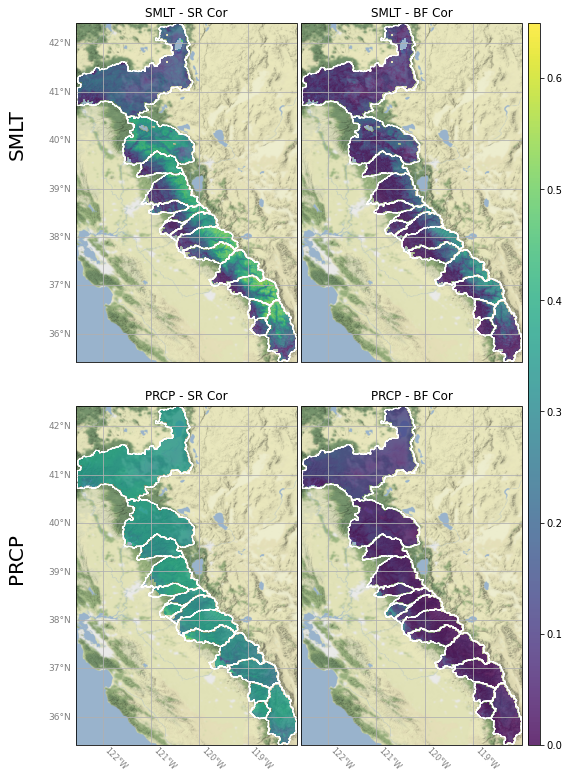

In [7]:
# Cors
fig, axes = plt.subplots(nrows=2, ncols=2,figsize = (8,14), subplot_kw={'projection': ccrs.PlateCarree()})

im = plot_basemaps(results['smlt_cor_sr'], "../shape/sierra_catchments.shp", "SMLT - SR Cor", cmap = 'viridis', ax = axes[0][0], latlabels = True, lonlabels = False)
plot_basemaps(results['smlt_cor_bf'], "../shape/sierra_catchments.shp", "SMLT - BF Cor", cmap = 'viridis', ax = axes[0][1], latlabels = False, lonlabels = False, vmax = 1)
plot_basemaps(results['prcp_cor_sr'], "../shape/sierra_catchments.shp", "PRCP - SR Cor", cmap = 'viridis', ax = axes[1][0], latlabels = True, lonlabels = True, vmax = 1)
plot_basemaps(results['prcp_cor_bf'], "../shape/sierra_catchments.shp", "PRCP - BF Cor", cmap = 'viridis', ax = axes[1][1], latlabels = False, lonlabels = True, vmax = 1)

# Ylabel
fig.text(.0055, 0.33, 'PRCP', va='center', rotation='vertical', size = 20)
fig.text(.0055, 0.75, 'SMLT', va='center', rotation='vertical', size = 20)

# spacing 
fig.subplots_adjust(wspace=0.02,hspace =0.0125)

# colorbar
cax = fig.add_axes([axes[0][-1].get_position().x1+0.01,axes[1][-1].get_position().y0,0.02,axes[0][-2].get_position().y1-axes[1][-1].get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)

plt.show()

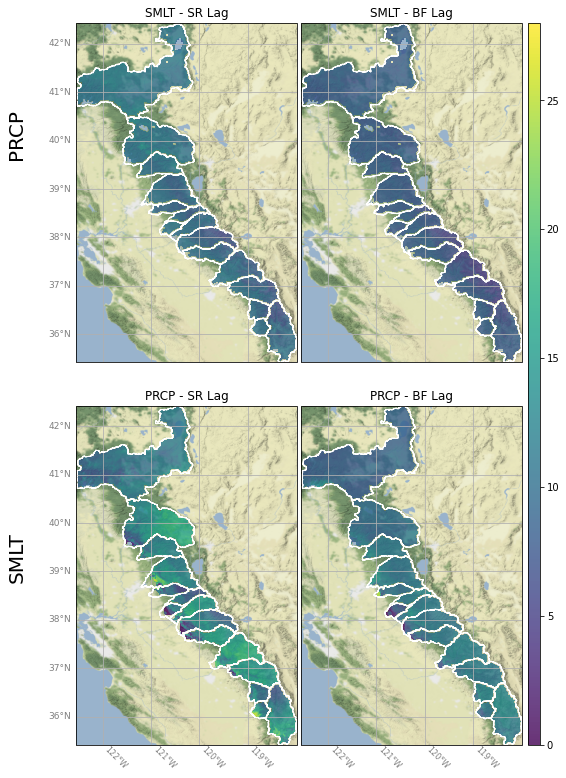

In [8]:
# Lags
fig, axes = plt.subplots(nrows=2, ncols=2,figsize = (8,14), subplot_kw={'projection': ccrs.PlateCarree()})

im = plot_basemaps(results['smlt_lag_sr'], "../shape/sierra_catchments.shp", "SMLT - SR Lag", cmap = 'viridis', ax = axes[0][0], latlabels = True, lonlabels = False)
plot_basemaps(results['smlt_lag_bf'], "../shape/sierra_catchments.shp", "SMLT - BF Lag", cmap = 'viridis', ax = axes[0][1], latlabels = False, lonlabels = False, vmax = 30)
plot_basemaps(results['prcp_lag_sr'], "../shape/sierra_catchments.shp", "PRCP - SR Lag", cmap = 'viridis', ax = axes[1][0], latlabels = True, lonlabels = True, vmax = 30)
plot_basemaps(results['prcp_lag_bf'], "../shape/sierra_catchments.shp", "PRCP - BF Lag", cmap = 'viridis', ax = axes[1][1], latlabels = False, lonlabels = True, vmax = 30)

# Ylabel
fig.text(.0055, 0.33, 'SMLT', va='center', rotation='vertical', size = 20)
fig.text(.0055, 0.75, 'PRCP', va='center', rotation='vertical', size = 20)

# spacing 
fig.subplots_adjust(wspace=0.02,hspace =0.0099)

# colorbar
cax = fig.add_axes([axes[0][-1].get_position().x1+0.01,axes[1][-1].get_position().y0,0.02,axes[0][-2].get_position().y1-axes[1][-1].get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)

plt.show()


# Elevation analysis

    create contours
    plot seasonal means as (f) elev for each contour interval
    To create the contours from a dem:

gdal_contour -a 'elev' hu6_srtm_dem.tif ../shape/contours_500m.shp -i 500.0 -p

<ipython-input-11-558ed3b64fe5>:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_under('k', alpha=0)


<AxesSubplot:title={'center':'500m elevation contours '}>

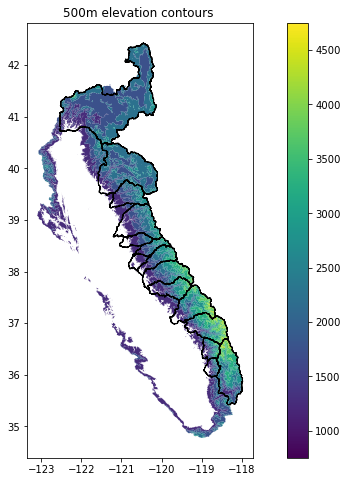

In [11]:
# ELEVATION ANALYSIS 

# Read elevation contours we made 
cont_gdf = gp.read_file("../shape/contours_500m.shp")
cont_gdf['elev'] = np.linspace(250,4750,10) # [int(x) * 500 for x in gdf['ID']] 

# Set alpha val in cmap
cmap = plt.get_cmap('viridis')
cmap.set_under('k', alpha=0)

# plot with watersehds 
ax = cont_gdf.plot(figsize = (12,8), column= 'elev',cmap = cmap, legend = True, vmin = 751)
plt.title('500m elevation contours ')
gp.read_file("../shape/sierra_catchments.shp").plot(ax = ax, facecolor = "none", edgecolor = 'black')

In [12]:
# Define the 500m contour interval 
heights = np.linspace(0,5000,11)
heights = ["{} - {}".format(str(x-500), str(x)) for x in heights]
heights[0] = "<0"

median_hts = np.linspace(250,4750,10)

# Read each contour interval shape
with fiona.open("../shape/contours_500m.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

len(shapes), len(median_hts)


(10, 10)

In [19]:
merged_dir = "../results/moving_win_30/merged/"

# Final results dict 
elev_res_fin = {}


for hvar in ['sum','cor_sr','lag_sr','cor_bf','lag_bf'][:]:
    for vartype in ['smlt_','prcp_'][:]:
        mean_fn = os.path.join(merged_dir,vartype+hvar+ ".tiff")
        print(mean_fn)

        # Set up dict for elevation results
        elev_res = {}

        # Loop through elevation contours
        for idx, shape in enumerate(shapes):
            with rasterio.open(mean_fn) as src:
                out_image, out_transform = rasterio.mask.mask(src, [shape], crop=True)
                outim = out_image.reshape(out_image.shape[1],out_image.shape[2])
                outim[outim==src.nodata]=np.nan #mask nodata vals
                outim[outim<=0] = np.nan
                elev_res[heights[idx]] = outim[~np.isnan(outim)].flatten()

        # Compile summary stats for each elevation bin 
        df_rows = []
        for k,v in elev_res.items():
            varmean = np.nanmedian(v)
            varstd = np.nanstd(v) #np.nanpercentile(v,66) - np.nanpercentile(v,50)
            var_n = len(~np.isnan(v)) # count non - nan elements 
            sumdf = pd.DataFrame([k,varmean,varstd,var_n]).T
            sumdf.columns = ['elev','{}_mean'.format(vartype+hvar),'{}_std'.format(vartype+hvar),'{}_num'.format(vartype+hvar)]
            df_rows.append(sumdf)

        # Concat the stats we just extracted 
        tdf = pd.concat(df_rows)
        tdf['elev'] = np.linspace(250,4750,10)
        tdf = tdf.astype(float).set_index("elev")

        elev_res_fin[vartype+hvar] = tdf


../results/moving_win_30/merged/smlt_sum.tiff
../results/moving_win_30/merged/prcp_sum.tiff
../results/moving_win_30/merged/smlt_cor_sr.tiff
../results/moving_win_30/merged/prcp_cor_sr.tiff
../results/moving_win_30/merged/smlt_lag_sr.tiff
../results/moving_win_30/merged/prcp_lag_sr.tiff
../results/moving_win_30/merged/smlt_cor_bf.tiff
../results/moving_win_30/merged/prcp_cor_bf.tiff
../results/moving_win_30/merged/smlt_lag_bf.tiff
../results/moving_win_30/merged/prcp_lag_bf.tiff


In [20]:
elev_res_fin

{'smlt_sum':         smlt_sum_mean  smlt_sum_std  smlt_sum_num
 elev                                             
 250.0             NaN           NaN           0.0
 750.0        0.002247      0.001297        5681.0
 1250.0       0.003679      0.001057       13025.0
 1750.0       0.003193      0.001363       26741.0
 2250.0       0.003429      0.001537       30023.0
 2750.0       0.004781      0.001283       13209.0
 3250.0       0.004806      0.001259        7520.0
 3750.0       0.004279      0.001051        3870.0
 4250.0       0.003003      0.000788         971.0
 4750.0       0.001717      0.000509          10.0,
 'prcp_sum':         prcp_sum_mean  prcp_sum_std  prcp_sum_num
 elev                                             
 250.0             NaN           NaN           0.0
 750.0        0.004669      0.186699        5839.0
 1250.0       0.118517      0.182524       13028.0
 1750.0       0.475973      0.331864       27036.0
 2250.0       0.906555      0.530987       30036.0
 2750.

In [ ]:
#  Plot

# Coppy the master outdict
season_f_smlt = season_res_fin.copy()

# Setup fig
plt.figure(figsize=(20,4))

# Seasonal Means
ax0 = plt.subplot(151)
ax0.set_title("Snowmelt Seasonal Means", size = 14)

vartype = 'smlt'
hvar = 'sum'
varmean = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].mean(axis = 1)
varstd = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].std(axis = 1)

ax0.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax0.errorbar(season_f_smlt['1']['smlt_1_sum_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['1']['smlt_1_sum_std'],label = 'Autumn', color = 'brown', alpha = 0.4)
ax0.errorbar(season_f_smlt['2']['smlt_2_sum_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['2']['smlt_2_sum_std'],label = 'Winter', color = 'blue',alpha = 0.4 )
ax0.errorbar(season_f_smlt['3']['smlt_3_sum_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['3']['smlt_3_sum_std'],label = 'Spring', color = 'green',alpha = 0.4 )
ax0.errorbar(season_f_smlt['4']['smlt_4_sum_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['4']['smlt_4_sum_std'],label = 'Summer', color = 'red', alpha = 0.4 )
ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.set_ylabel("elevation(m)", size = 15)
ax0.set_xlabel("Mean (mm)", size =12)

ax0.legend()
ax0.legend(loc='upper center', bbox_to_anchor=(1.25, -.25), ncol=5, fontsize = 12, fancybox=True, shadow=True)

# Seasonal Correlations
ax1 = plt.subplot(152)
ax1.set_title("Snowmelt - Q Correlation", size = 14)

vartype = 'smlt'
hvar = 'cor'
varmean = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].mean(axis = 1)
varstd = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].std(axis = 1)

ax1.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax1.errorbar(season_f_smlt['1']['smlt_1_cor_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['1']['smlt_1_cor_std'],color = 'brown', alpha = 0.4)
ax1.errorbar(season_f_smlt['2']['smlt_2_cor_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['2']['smlt_2_cor_std'], color = 'blue', alpha = 0.4)
ax1.errorbar(season_f_smlt['3']['smlt_3_cor_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['3']['smlt_3_cor_std'], color = 'green', alpha = 0.4 )
ax1.errorbar(season_f_smlt['4']['smlt_4_cor_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['4']['smlt_4_cor_std'], color = 'red', alpha = 0.4)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set(yticklabels=[])  
ax1.set_xlim([0,.75])
ax1.set_xlabel("Correlation", size = 12)

# Seasonal lagrelations
ax2 = plt.subplot(153)
ax2.set_title("Snowmelt - Q Lag (days)", size = 14)

vartype = 'smlt'
hvar = 'lag'
varmean = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].mean(axis = 1)
varstd = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].std(axis = 1)

ax2.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax2.errorbar(season_f_smlt['1']['smlt_1_lag_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['1']['smlt_1_lag_std'],color = 'brown', alpha = 0.4)
ax2.errorbar(season_f_smlt['2']['smlt_2_lag_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['2']['smlt_2_lag_std'], color = 'blue', alpha = 0.4)
ax2.errorbar(season_f_smlt['3']['smlt_3_lag_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['3']['smlt_3_lag_std'], color = 'green', alpha = 0.4 )
ax2.errorbar(season_f_smlt['4']['smlt_4_lag_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['4']['smlt_4_lag_std'], color = 'red', alpha = 0.4)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set(yticklabels=[])  
ax2.set_xlabel("lag (days)", size = 12)
ax2.set_xlim([0,40])

# Seasonal MI
ax3 = plt.subplot(154)
ax3.set_title("Snowmelt - Q MI (nats)", size = 14)

vartype = 'smlt'
hvar = 'mi'
varmean = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].mean(axis = 1)
varstd = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].std(axis = 1)

ax3.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax3.errorbar(season_f_smlt['1']['smlt_1_mi_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['1']['smlt_1_mi_std'],color = 'brown', alpha = 0.4)
ax3.errorbar(season_f_smlt['2']['smlt_2_mi_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['2']['smlt_2_mi_std'], color = 'blue', alpha = 0.4)
ax3.errorbar(season_f_smlt['3']['smlt_3_mi_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['3']['smlt_3_mi_std'], color = 'green', alpha = 0.4 )
ax3.errorbar(season_f_smlt['4']['smlt_4_mi_mean'], season_f_smlt['1'].index, xerr =season_f_smlt['4']['smlt_4_mi_std'], color = 'red', alpha = 0.4)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.set(yticklabels=[])  
ax3.set_xlabel("MI (nats)", size = 12)
ax3.set_xlim([0.4,1.8])


plt.subplot(155)
num_smlt.columns = ['Autumn', "Winter", "Spring", "Summer"]
ax4 = num_smlt.plot(kind = 'barh', ax = plt.gca(),color = ['brown', 'blue', 'green', 'red'])
ax4.tick_params(axis='both', which='major', labelsize=12)
ax4.set(yticklabels=[])  
ax4.set_ylabel("")  
ax4.set_xlabel("N")  
ax4.set_title("Npixels", size = 14)
ax4.set_xlim([0,30000])
plt.show()
